## Binary classification problem

### Dataset :

We study first a binary classification problem, performed by a neural network. Each input has two real features, and the output can be only 0 or 1. The training set contains 4000 examples, and the validation set, 1000.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Display figures on jupyter notebook
%matplotlib inline

In [3]:
# Define a function to generate the dataset, in the form of two interlaced spirals
def spiral(phi):
    x = (phi+1)*torch.cos(phi)
    y = phi*torch.sin(phi)
    return torch.cat((x, y), dim=1)

def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(0, 10)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.3)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data//2:,:] *= -1
    labels[num_data//2:] = 1
    return data, labels

In [4]:
# Generate the training set with 4000 examples by function generate_data

X_train, y_train = generate_data(4000)
X_train.size()

torch.Size([4000, 2])

In [5]:
# Define the vis_data function to visualize the dataset
def vis_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.plot(X[y==1, 0].numpy(), X[y==1, 1].numpy(), 'r+') #Examples are represented as red plusses for label 1
    plt.plot(X[y==0, 0].numpy(), X[y==0, 1].numpy(), 'b+') #Examples are represented as blue plusses for label 0 

We can now invoke the `vis_data` function on the dataset previously generated to see what it looks like:

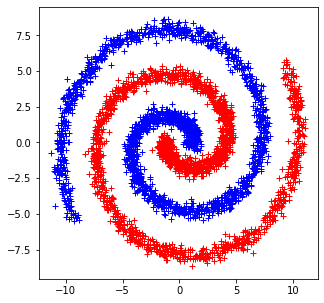

In [6]:
vis_data(X_train, y_train) # visualize training set

We use the `TensorDataset` wrapper from pytorch, so that the framework can easily understand our tensors as a proper dataset.

In [7]:
from torch.utils.data import TensorDataset, DataLoader
training_set = TensorDataset(X_train, y_train)

###  Training the model with a neural network

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll work on to improve it during this exercise.

Look at the code and run it to see the structure, then follow the questions below to iteratively improve the model.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

At the first step, we define a neural network with just one layer. A useful tutorial for constructing model can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [9]:
# Basic network structure with a single layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # A single linear layer
        # The model has 2 inputs (the coordinates of the point) and an output (the prediction)
        self.l1 = nn.Linear(2, 1)
        
    def forward(self, inputs):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        outputs = torch.sigmoid(self.l1(inputs))
        return outputs

In [10]:
# Create the model: 
simple_model = Model()
print(simple_model)

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(simple_model.parameters(), lr=0.01)

Model(
  (l1): Linear(in_features=2, out_features=1, bias=True)
)


#### Training the defined model
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [11]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset, display=True):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        if display:
            print('Epoch [{}/{}], Loss: {:.4f}'
                          .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [12]:
train_error = train(num_epochs, batch_size, criterion, optimizer, simple_model, training_set)

Epoch [1/10], Loss: 0.2411
Epoch [2/10], Loss: 0.2345
Epoch [3/10], Loss: 0.2335
Epoch [4/10], Loss: 0.2334
Epoch [5/10], Loss: 0.2331
Epoch [6/10], Loss: 0.2327
Epoch [7/10], Loss: 0.2329
Epoch [8/10], Loss: 0.2328
Epoch [9/10], Loss: 0.2331
Epoch [10/10], Loss: 0.2330


Text(0.5, 1.0, 'Visualization of convergence')

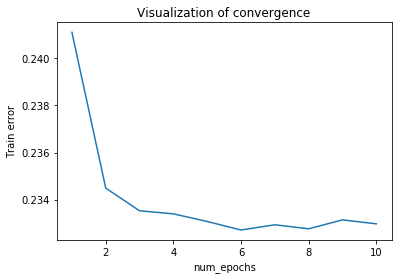

In [13]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

#### Evaluate the model on the validation set

In [14]:
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)
y_val = y_val.type(torch.float32)

In [15]:
# predict labels for validation set
simple_model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = simple_model(X_val).view(-1)

In [16]:
# Calculate the accuracy on validation set to evaluate the model by the function accuracy
def accuracy(y_real, y_pre, return_value=False, display=True):
    y_pre[y_pre<0.5] = 0
    y_pre[y_pre>=0.5] = 1

    acc = 1 - torch.sum(torch.abs(y_pre - y_real))/len(y_pre)
    if display:
        print('Accuracy of the network on the 1000 validation data: {:.2f} %'.format(acc.item()*100))
    
    if return_value:
        return acc

In [17]:
acc = accuracy(y_val, y_pre, return_value=True)

Accuracy of the network on the 1000 validation data: 58.20 %


In [43]:
# Compare the prediction with real labels

def predict(model, x, no_sigmoid=False):
    model.eval() # set the model to test mode
    with torch.no_grad():
        if no_sigmoid:
            y_pre = torch.sigmoid(model(torch.from_numpy(x).type(torch.float32))).view(-1)
        else:
            y_pre = model(torch.from_numpy(x).type(torch.float32)).view(-1)
    return y_pre

def compare_pred(X, y_real, y_pre, model, train_error, accuracy, title='', no_sigmoid=False):
    plt.figure(figsize=(16, 4))
    plt.suptitle(title)
    
    ### Plot the learning curve
    # plot the training error wrt. the number of epochs: 
    plt.subplot(141)
    plt.plot(range(1, len(train_error)+1), train_error)
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")

    ### Plot the ground truth
    plt.subplot(142)
    plt.plot(X[y_real==1, 0].numpy(), X[y_real==1, 1].numpy(), 'r+') #Examples are represented as a red plusses for label 1
    plt.plot(X[y_real==0, 0].numpy(), X[y_real==0, 1].numpy(), 'b+') #Examples are represented as a blue plusses for label 0
    plt.title("real data")

    ### Plot our results
    plt.subplot(143)
    plt.plot(X[y_pre==1, 0].numpy(), X[y_pre==1, 1].numpy(), 'r+')
    plt.plot(X[y_pre==0, 0].numpy(), X[y_pre==0, 1].numpy(), 'b+')
    plt.title("prediciton results, $\mathbf{Acc : %.2f \%%}$" % (accuracy.item()*100))
    
    ### Plot our results with decision boundaries
    plt.subplot(144)
    plt.plot(X[y_pre==1, 0].numpy(), X[y_pre==1, 1].numpy(), 'r+')
    plt.plot(X[y_pre==0, 0].numpy(), X[y_pre==0, 1].numpy(), 'b+')
    plt.title("decision boundary")
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    predicter = lambda x: predict(model, x, no_sigmoid)
    Z = predicter(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)

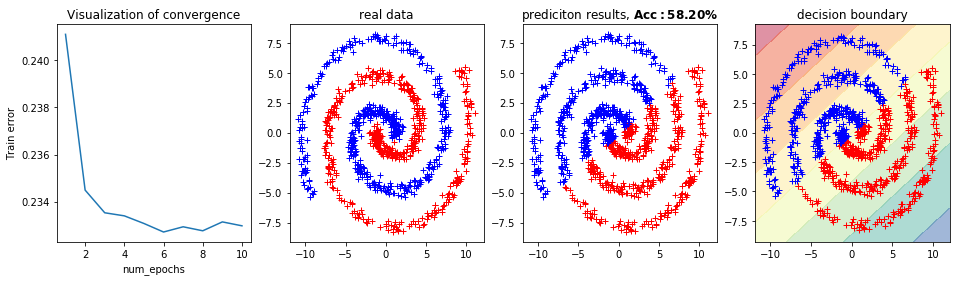

In [19]:
compare_pred(X_val, y_val, y_pre, simple_model, train_error, accuracy=acc)

> We plot the decision boundary in order to clearly see whether the model finds a non linear pattern in the data or not and how it deals with it. Moreover it helps a lot assessing how much the model is overfitting.

### Exercice 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons for each layer (5, 10, 20, more ?)

**In our study, we will restrict ourselves to evaluating final performances of models with a specific set of parameters.** However, evaluating how well do models perform intrinsically or if we train them only for a few epochs is very interesting as well. Considerations such as the number of parameters in the model will have a high impact on the training and thus the performances if we stop the process early. We could implement an early stopping tool to stop the training when the performances can't increase, however in the case of our task we consider that you cannot overfit that much and using early stopping to save some time might not be worth it since training executes in a few seconds.

In [20]:
class MultiLayerModel(nn.Module):
    def __init__(self, n_hidden_layers=0, n_neurons=2, hidden_activations=torch.relu, 
                 output_activation=torch.sigmoid):
        super(MultiLayerModel, self).__init__()
        self.n_layers = n_hidden_layers
        if type(n_neurons)==int:
            self.n_neurons = [2] + [n_neurons for _ in range(n_hidden_layers)]
        else:
            assert type(n_neurons)==list
            assert len(n_neurons)==n_hidden_layers
            self.n_neurons = [2] + n_neurons
        
        for i in range(self.n_layers):
            input_dim = self.n_neurons[i]
            output_dim = self.n_neurons[i+1]
            setattr(self,
                    "layer_{}".format(i+1),
                    nn.Linear(input_dim, output_dim))
        
        self.out = nn.Linear(self.n_neurons[-1], 1)
        
        self.hidden_activations = hidden_activations
        self.output_activation = output_activation
    
    def forward(self, inputs):
        x = inputs
        for i in range(self.n_layers):
            x = getattr(self, "layer_{}".format(i+1))(x)
            if i < self.n_layers - 1:
                x = self.hidden_activations(x)
        outputs = self.output_activation(self.out(x))
        return outputs

In [40]:
n_hidden_layers=3
n_neurons=10

# Choose the hyperparameters for training: 
num_epochs = 100
batch_size = 64

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
model = MultiLayerModel(n_hidden_layers, n_neurons)
print('The model used is :\n', model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set, display=False)

The model used is :
 MultiLayerModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)


Text(0.5, 1.0, 'Visualization of convergence')

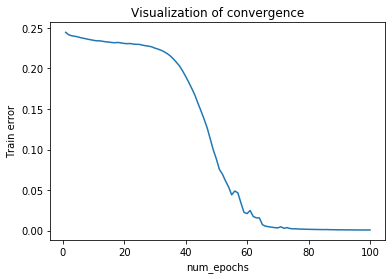

In [22]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

Accuracy of the network on the 1000 validation data: 99.90 %


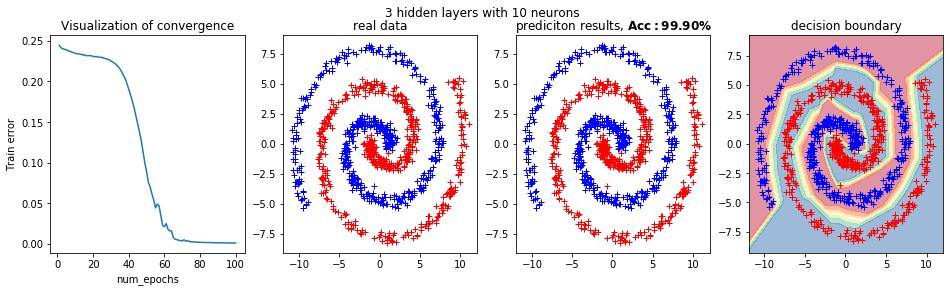

In [23]:
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)
acc = accuracy(y_val, y_pre, return_value=True)
compare_pred(X_val, y_val, y_pre, model, train_error, accuracy=acc, 
                 title='{} hidden layers with {} neurons'.format(n_hidden_layers, n_neurons))

> This set of parameters works very well but it might be a bit overkill... At least we know that an excellent model can be found !

**Impact of the number of hidden layers :**

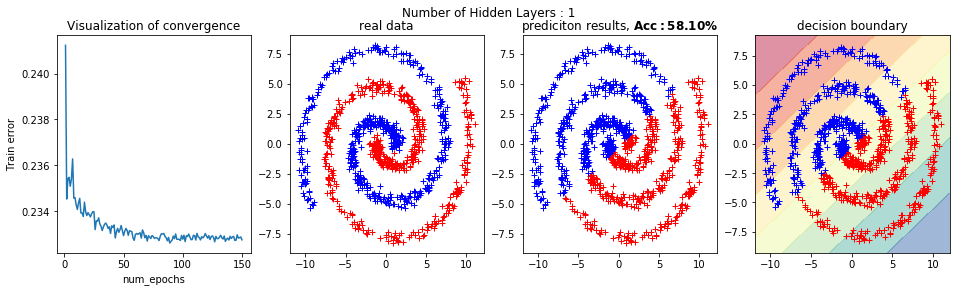

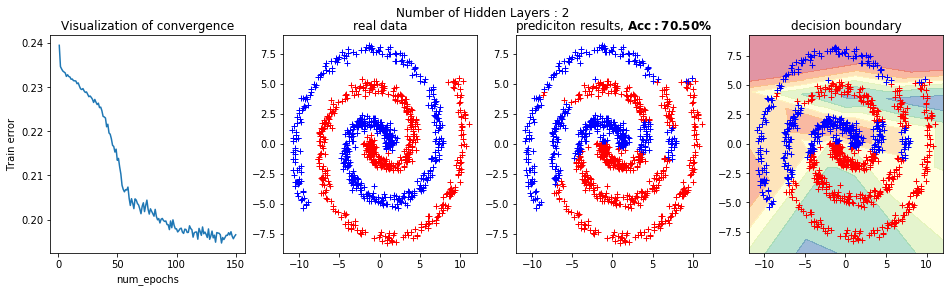

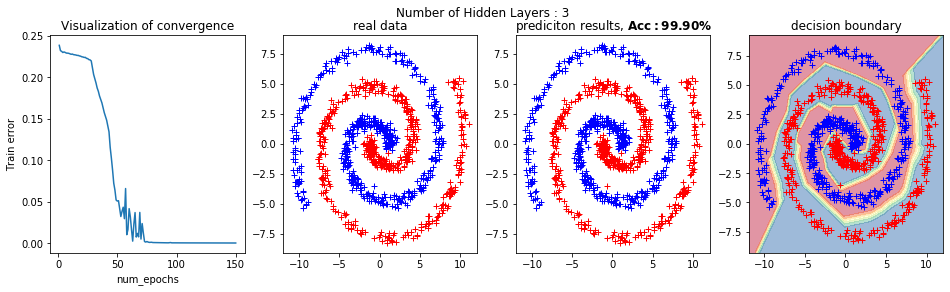

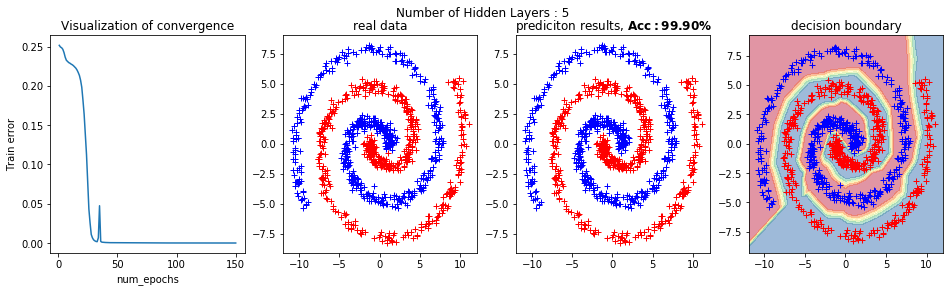

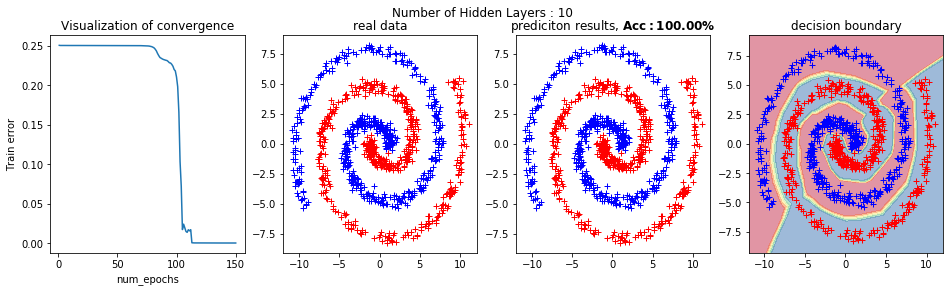

In [27]:
num_epochs = 150
batch_size = 32
test_hidden_layers = [1,2,3,5,10]
for h_l in test_hidden_layers:
    ### Train the model
    model = MultiLayerModel(h_l, n_neurons, 
                            hidden_activations=torch.relu, output_activation=torch.sigmoid)
    #print('The model used is :\n', model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set, display=False)

    ### Evaluate the model and plot the results
    model.eval() # set the model to test mode
    with torch.no_grad():
        y_pre = model(X_val).view(-1)
    acc = accuracy(y_val, y_pre, return_value=True, display=False)
    compare_pred(X_val, y_val, y_pre, model, train_error, accuracy=acc, 
                 title='Number of Hidden Layers : {}'.format(h_l))

> Not surprisingly, one layer can only represent linear decision boundaries, two layers can get a bit more complex patterns and if we increase the number of layers (warning : bigger model require more time to train their huge amount of parameters), then the performances don't get much better but we clearly see differences in the decision boundaries. The more the layers, the thiner is the decision boundary and the less edgy. With 10 layers it is very smooth but might overfit a bit.

NB : a possible explanation for the observed performance gap between 2 layers and 3 layers could be the following : if you consider only one neuron per layer then a 3 layers model will be able to fit a U shape somehow, whereas a 2 layer model can't. Our task can be seen as finding U shapes in the data, hence the gap in the performance.

<table style="width:40%">
<tr>
<th>Number of Hidden Layers</th>
<th>Classification Accuracy</th>
<th>Decision Boundary</th>
</tr>

<tr>
<td>10</td>
<td>100.00%</td>
<td>Thin + Overfit</td>
</tr>

<tr>
<td>5</td>
<td>90.90%</td>
<td>~Large + Smooth</td>
</tr>

<tr>
<td>3</td>
<td>90.90%</td>
<td>~Thin + Edgy</td>
</tr>

<tr>
<td>2</td>
<td>78.50%</td>
<td>-</td>
</tr>

<tr>
<td>1</td>
<td>58.10%</td>
<td>-</td>
</tr>

</table>

---

**Impact of the activation function :**

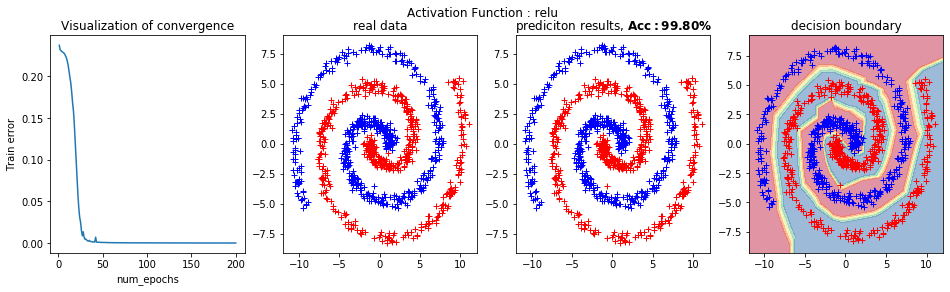

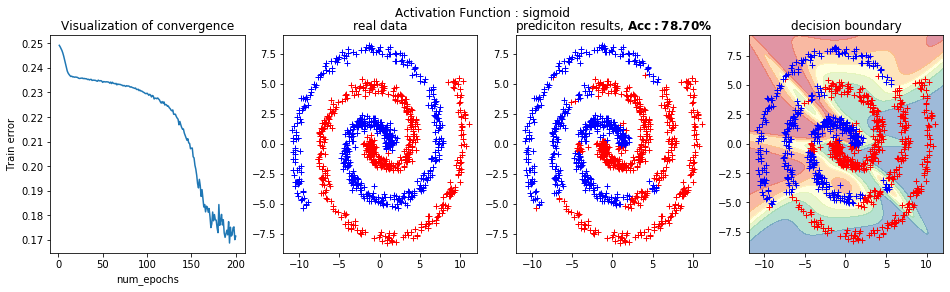

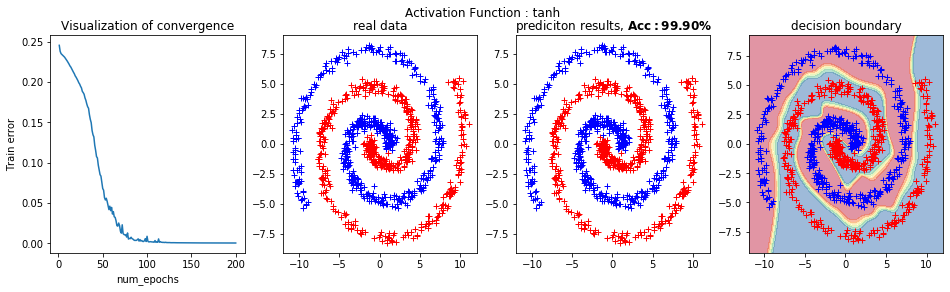

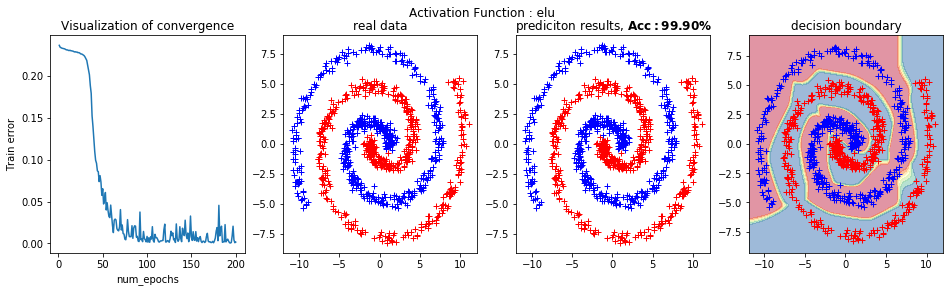

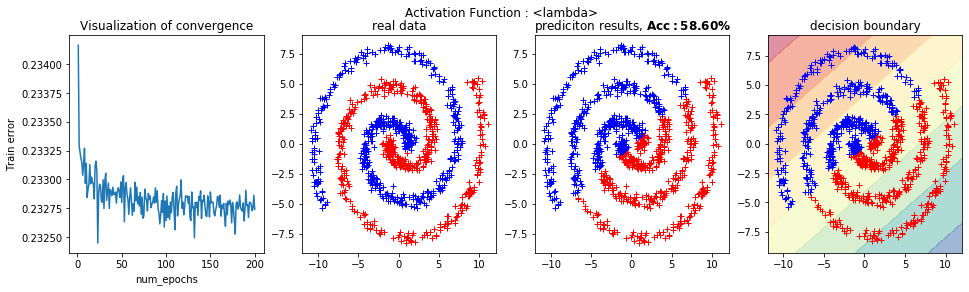

In [42]:
num_epochs = 200
batch_size = 32
test_activations = [torch.relu, torch.sigmoid, torch.tanh, torch.nn.functional.elu, lambda x: x]
for activation_fct in test_activations:
    ### Train the model
    model = MultiLayerModel(n_hidden_layers=3, n_neurons=10, 
                            hidden_activations=activation_fct, output_activation=torch.sigmoid)
    #print('The model used is :\n', model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set, display=False)

    ### Evaluate the model and plot the results
    model.eval() # set the model to test mode
    with torch.no_grad():
        y_pre = model(X_val).view(-1)
    acc = accuracy(y_val, y_pre, return_value=True, display=False)
    compare_pred(X_val, y_val, y_pre, model, train_error, accuracy=acc, 
                 title='Activation Function : {}'.format(activation_fct.__name__))

> In general the Rectified Linear Unit performs very well and is the preferred choice. However, in this case the exponential linear unit is the one that performs best ! A centered function such as tanh also yields better results in this case than non-centered functions such as sigmoid.

> With ELU activation function we notice a smoother decision boundary than with Relu activation function. This is probably due to its derivable property of ELU function.

<table style="width:40%">
<tr>
<th>activation Function</th>
<th>Classification Accuracy</th>
<th>Decision Boundary</th>
</tr>

<tr>
<td>ReLU</td>
<td>99.80%</td>
<td>~Thin + ~Smooth</td>
</tr>

<tr>
<td>ELU</td>
<td>99.90%</td>
<td>Thin + ~Smooth</td>
</tr>

<tr>
<td>tanh</td>
<td>99.90%</td>
<td>~Thin + ~Edgy</td>
</tr>

<tr>
<td>Sigmoid</td>
<td>78.70%</td>
<td>Very bad</td>
</tr>

<tr>
<td>None</td>
<td>58.60%</td>
<td>-</td>
</tr>

</table>

---

**Impact of the number of neurons :**

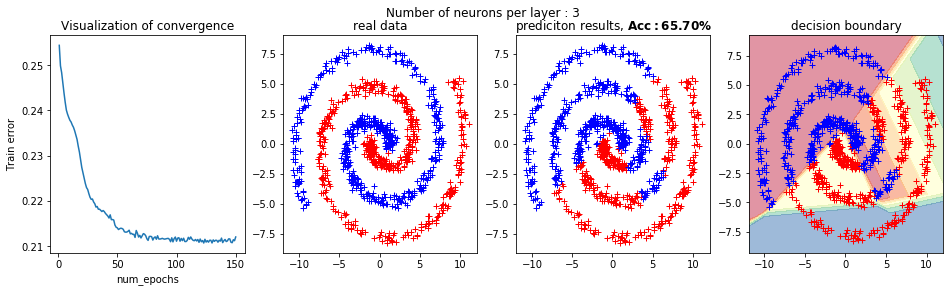

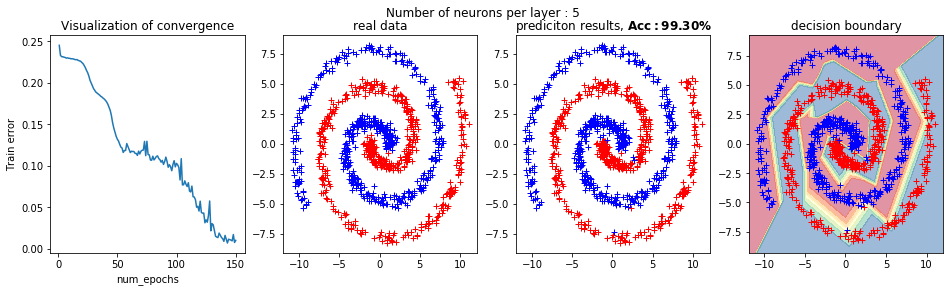

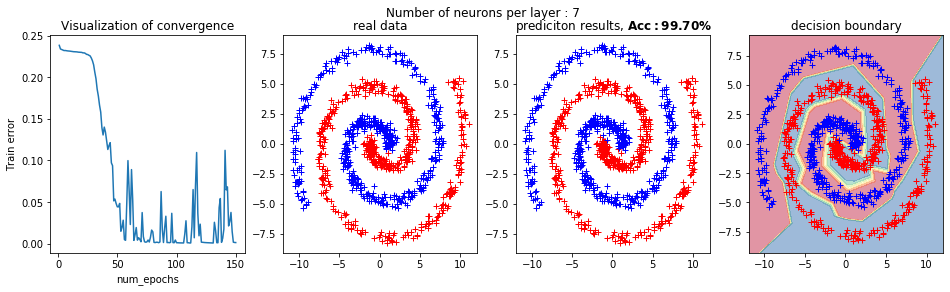

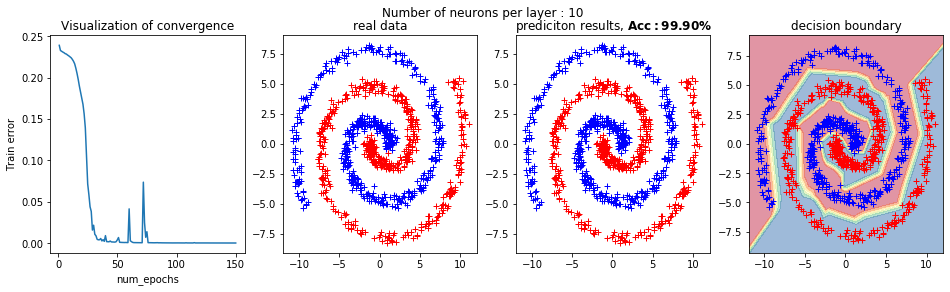

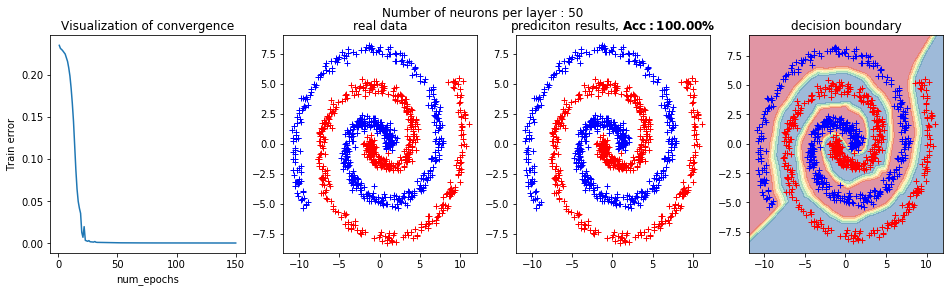

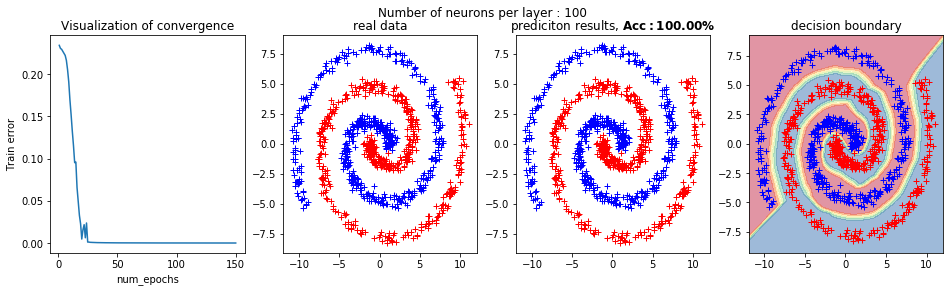

In [41]:
num_epochs = 150
batch_size = 32
test_neurons = [3,5,7,10,50,100]
for neuron in test_neurons:
    ### Train the model
    model = MultiLayerModel(n_hidden_layers=3, n_neurons=neuron, 
                            hidden_activations=torch.relu, output_activation=torch.sigmoid)
    #print('The model used is :\n', model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set, display=False)

    ### Evaluate the model and plot the results
    model.eval() # set the model to test mode
    with torch.no_grad():
        y_pre = model(X_val).view(-1)
    acc = accuracy(y_val, y_pre, return_value=True, display=False)
    compare_pred(X_val, y_val, y_pre, model, train_error, accuracy=acc, 
                 title='Number of neurons per layer : {}'.format(neuron))

> It is worth noticing that choosing only one neuron per layer whould actually look like joining segments to fit a polynomial curve. We think that this way, one can only approximate a U shape function but cannot approximate one that rounds around itself like a spiral... Another interesting remark would be that intuitively to separate both spirals you would dive into 3D with a class in the positive part of the new dimension and the other class in the negative part and the two spirals in the new dimension would look like a spring. Then using a simple plan, you would be able to split both classes. When you use 3 neurons in a hidden layer, you somehow try to find a 3D representation of your data. This is our proposition to explain that from 3 neurons per layer, a model could theoretically fit the data.

<table style="width:40%">
<tr>
<th>Number of Neurons in Hidden Layer</th>
<th>Classification Accuracy</th>
<th>Decision Boundary</th>
</tr>

<tr>
<td>100</td>
<td>100.00%</td>
<td>~Thin + Smooth</td>
</tr>

<tr>
<td>50</td>
<td>100.00%</td>
<td>~Thin + Smooth</td>
</tr>

<tr>
<td>10</td>
<td>99.90%</td>
<td>~Thin + ~Edgy</td>
</tr>

<tr>
<td>7</td>
<td>99.70%</td>
<td>Thin + Edgy</td>
</tr>

<tr>
<td>5</td>
<td>99.30%</td>
<td>~Large + Very Edgy</td>
</tr>

<tr>
<td>3</td>
<td>65.70</td>
<td>-</td>
</tr>

</table>

---
---
---

### Exercice 2: Impact of the optimizer

Retrain the model by using different parameters of the optimizer, you can change its parameter in the cell initializing it, after the definition of your model.

* Use different batch size from 10 to 400
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the trainig process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

**Impact of the batch size :**

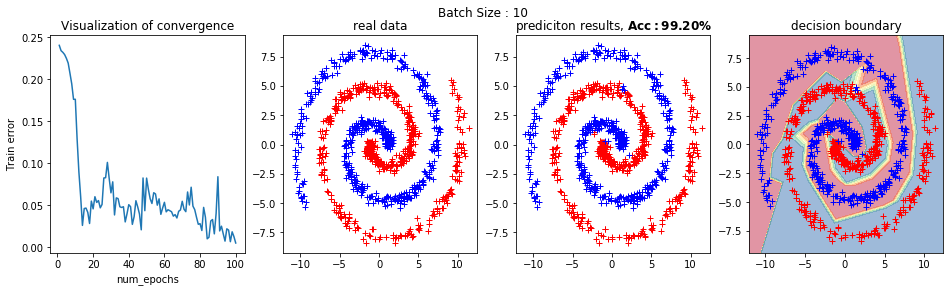

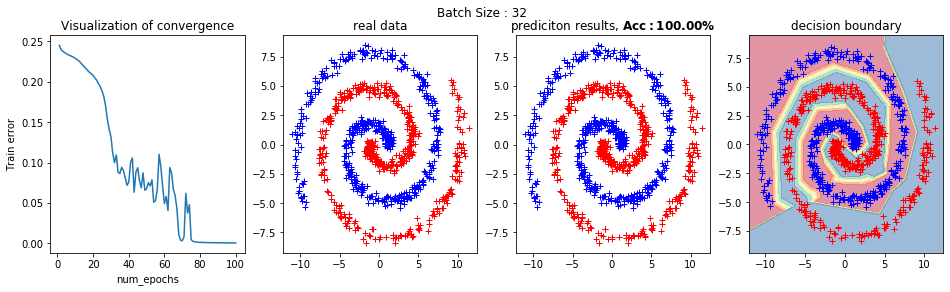

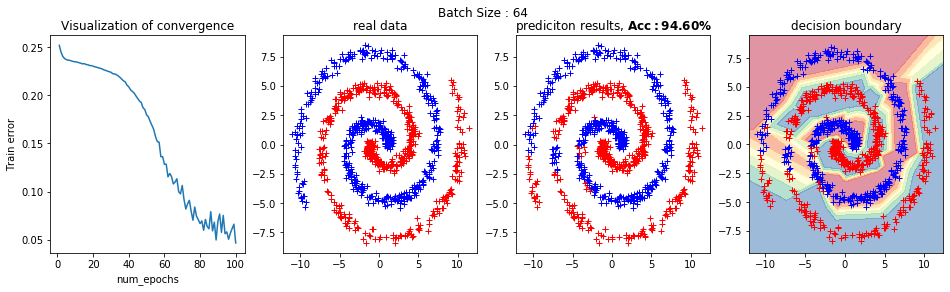

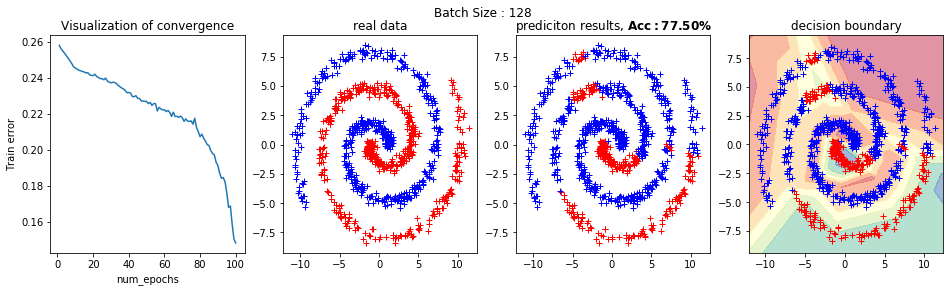

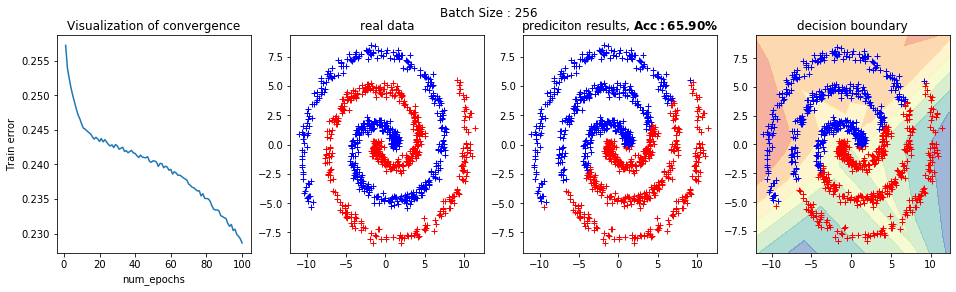

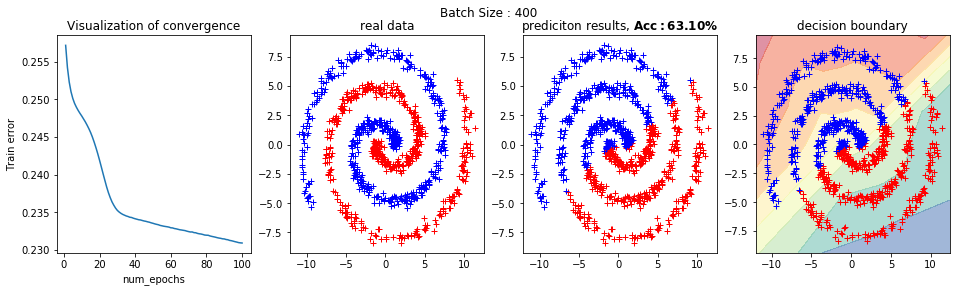

In [324]:
test_batch_size = [10,32,64,128,256,400]
for b_s in test_batch_size:
    ### Train the model
    model = MultiLayerModel(n_hidden_layers=3, n_neurons=7, 
                            hidden_activations=torch.relu, output_activation=torch.sigmoid)
    #print('The model used is :\n', model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, b_s, criterion, optimizer, model, training_set, display=False)

    ### Evaluate the model and plot the results
    model.eval() # set the model to test mode
    with torch.no_grad():
        y_pre = model(X_val).view(-1)
    acc = accuracy(y_val, y_pre, return_value=True, display=False)
    compare_pred(X_val, y_val, y_pre, model, train_error, accuracy=acc, 
                 title='Batch Size : {}'.format(batch_size))

> We notice there is a trade-off between the representativeness of the model and the number of updates. From a batch-size of 32, we manage to have a good representation of our spiral and enough updates to fit the model.
When the batch-size is too small (10 for example) we see there is a lack of representativeness but it is compensated by the big number of updates, here 400.
On the contrary, when the batch-size is higher than 32, for exmaple 400, the number of updates is not sufficient (only 10) to fit the model despite the representativeness of the pattern in the sample.

<table style="width:40%">
<tr>
<th>Batch size</th>
<th>Classification Accuracy</th>
<th>Decision Boundary</th>
</tr>

<tr>
<td>10</td>
<td>99.20%</td>
<td>Very Thin + Very Edgy</td>
</tr>

<tr>
<td>32</td>
<td>100.00%</td>
<td>~Thin + ~Edgy</td>
</tr>

<tr>
<td>64</td>
<td>94.60%</td>
<td>Bad, Large, Edgy</td>
</tr>

<tr>
<td>128</td>
<td>77.50%</td>
<td>Very bad</td>
</tr>

<tr>
<td>256</td>
<td>65.90%</td>
<td>-</td>
</tr>

<tr>
<td>400</td>
<td>63.10%</td>
<td>-</td>
</tr>

</table>

---

**Impact of the learning rate for several models :**
# TO DO : FIND A WAY TO PLOT A NICE GRAPH FOR DIFFERENT MODELS
Perhaps, plot all the training curves on the same graph and plot the graphs only for the best one (That we specify) ? And iterate on the chosen model...

But we have the issue of the number of epochs and the batch size because those are very related...

In [ ]:
batch_size=32
test_learning_rate = [0.001,0.01,0.1,1,10]
for lr in test_learning_rate:
    ### Train the model
    model = MultiLayerModel(n_hidden_layers=3, n_neurons=7, 
                            hidden_activations=torch.relu, output_activation=torch.sigmoid)
    #print('The model used is :\n', model)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set, display=False)

    ### Evaluate the model and plot the results
    model.eval() # set the model to test mode
    with torch.no_grad():
        y_pre = model(X_val).view(-1)
    acc = accuracy(y_val, y_pre, return_value=True, display=False)
    compare_pred(X_val, y_val, y_pre, model, train_error, accuracy=acc, 
                 title='Learning Rate : {}'.format(lr))

---

**Impact of the number of epochs :**

We already know that the number of epochs will highly impact the results but it is very interesting to have a look at how it impacts the results (GIF ?).

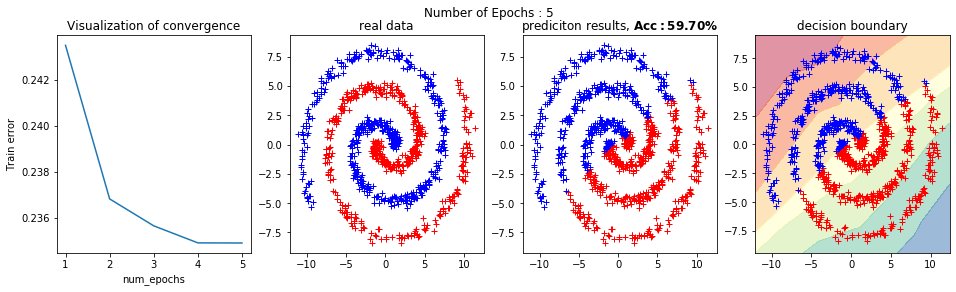

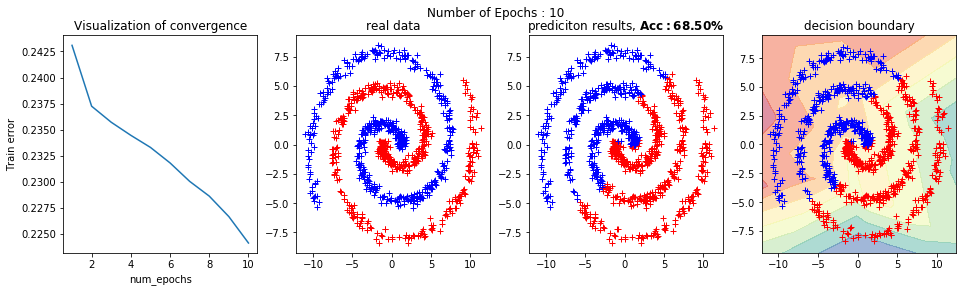

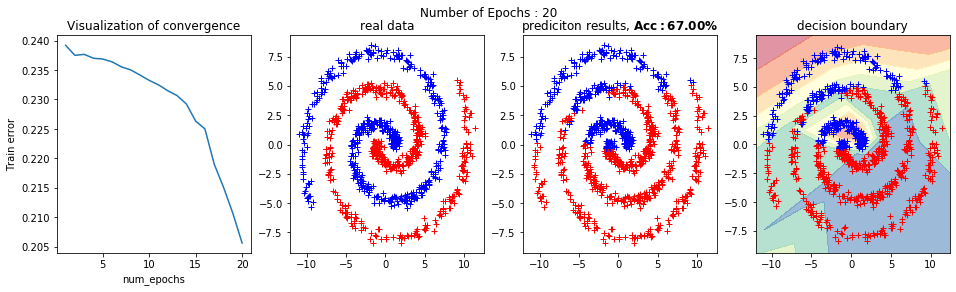

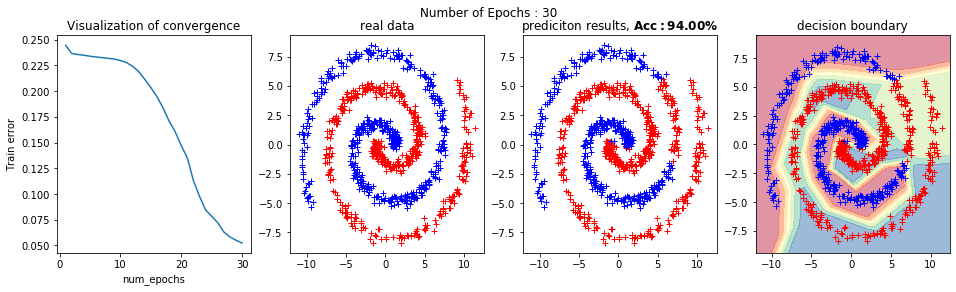

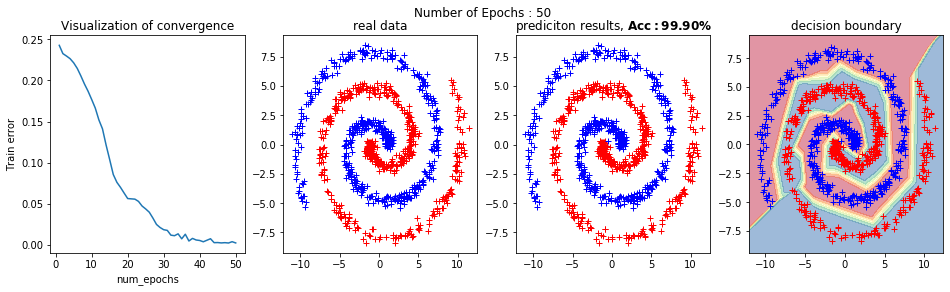

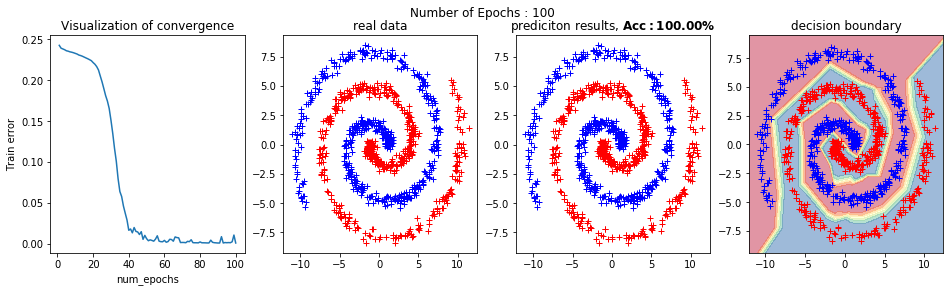

In [328]:
batch_size=32
test_epochs = [5,10,20,30,50,100]
for epochs in test_epochs:
    ### Train the model
    model = MultiLayerModel(n_hidden_layers=3, n_neurons=7, 
                            hidden_activations=torch.relu, output_activation=torch.sigmoid)
    #print('The model used is :\n', model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(epochs, batch_size, criterion, optimizer, model, training_set, display=False)

    ### Evaluate the model and plot the results
    model.eval() # set the model to test mode
    with torch.no_grad():
        y_pre = model(X_val).view(-1)
    acc = accuracy(y_val, y_pre, return_value=True, display=False)
    compare_pred(X_val, y_val, y_pre, model, train_error, accuracy=acc, 
                 title='Number of Epochs : {}'.format(epochs))

<table style="width:40%">
<tr>
<th>Number of epochs</th>
<th>Classification Accuracy</th>
<th>Decision Boundary</th>
</tr>

<tr>
<td>100</td>
<td>100.00%</td>
<td>~Thin + ~Edgy</td>
</tr>

<tr>
<td>50</td>
<td>99.90%</td>
<td>~Thin + Edgy</td>
</tr>

<tr>
<td>30</td>
<td>94.00%</td>
<td>Bad, Large, Edgy</td>
</tr>

<tr>
<td>20</td>
<td>67.00%</td>
<td>-</td>
</tr>

<tr>
<td>10</td>
<td>68.50%</td>
<td>-</td>
</tr>

<tr>
<td>5</td>
<td>59.70%</td>
<td>-</td>
</tr>

</table>

---

**Impact of the optimizer :**

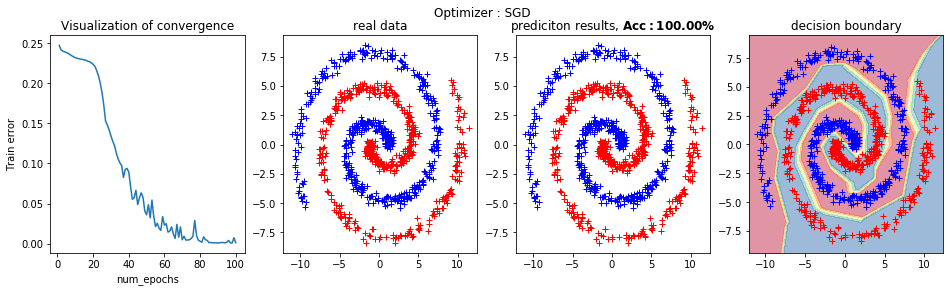

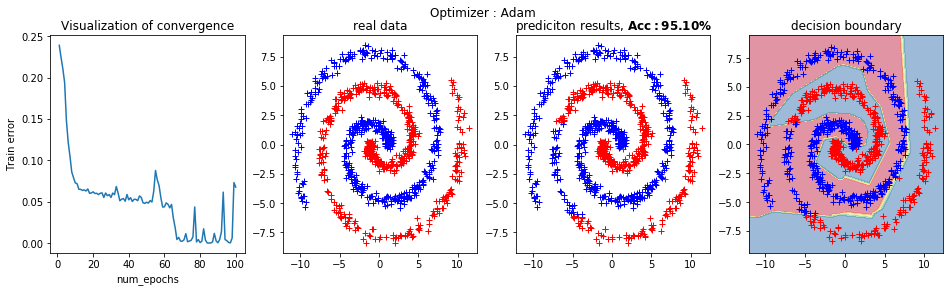

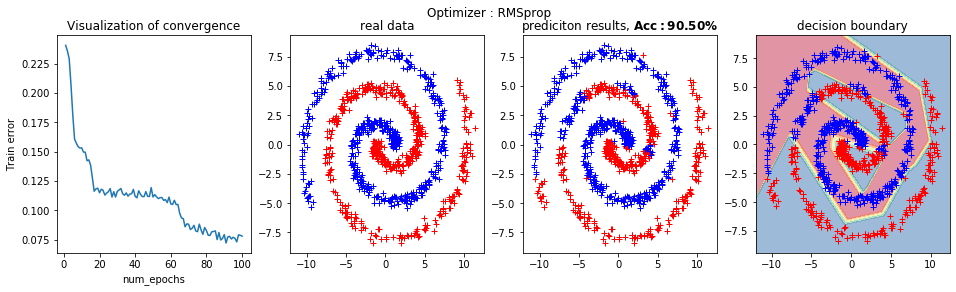

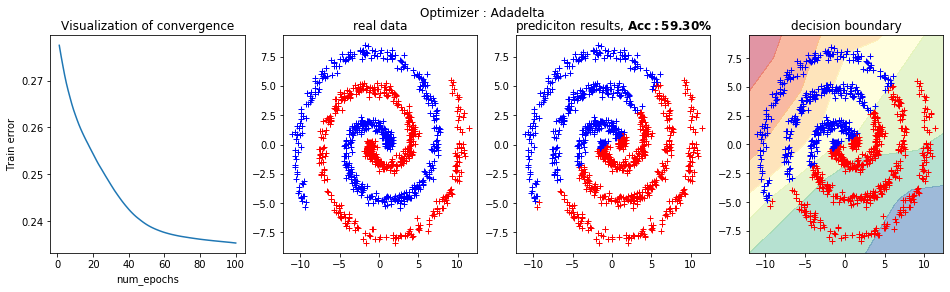

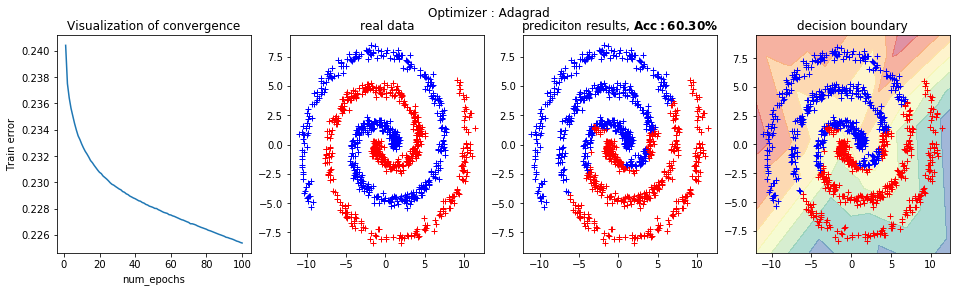

In [371]:
test_optimizers = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop, 
                   torch.optim.Adadelta, torch.optim.Adagrad]
for optim in test_optimizers:
    ### Train the model
    model = MultiLayerModel(n_hidden_layers=3, n_neurons=7, 
                            hidden_activations=torch.relu, output_activation=torch.sigmoid)
    #print('The model used is :\n', model)
    optimizer = optim(model.parameters(), lr=0.01)
    if optim.__name__=='SGD':
        state = optimizer.__getstate__()
        state['param_groups'][0]['lr'] = 0.1
        optimizer.__setstate__(state)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set, display=False)

    ### Evaluate the model and plot the results
    model.eval() # set the model to test mode
    with torch.no_grad():
        y_pre = model(X_val).view(-1)
    acc = accuracy(y_val, y_pre, return_value=True, display=False)
    compare_pred(X_val, y_val, y_pre, model, train_error, accuracy=acc, 
                 title='Optimizer : {}'.format(optim.__name__))

> Very interestingly, SGD is the optimizer that performs best by far ! Adadelta and Adagrad are very bad which is worth noticing, but the most important information is that Adam and RMS Prop clearly overfit the data as can be seen on the decision boundary maps (even though they yield good performance).

<table style="width:40%">
<tr>
<th>Optimizer</th>
<th>Classification Accuracy</th>
<th>Decision Boundary</th>
</tr>

<tr>
<td>SGD</td>
<td>100.00%</td>
<td>Thin + ~Smooth</td>
</tr>

<tr>
<td>Adam</td>
<td>95.10%</td>
<td>Bad + Overfit</td>
</tr>

<tr>
<td>RMSprop</td>
<td>90.50%</td>
<td>Bad + Overfit</td>
</tr>

<tr>
<td>Adadelta</td>
<td>59.30%</td>
<td>-</td>
</tr>

<tr>
<td>Adagrad</td>
<td>60.30%</td>
<td>-</td>
</tr>

</table>

---
---
---

### Exercice 3: Impact of the loss function

The current model uses a mean square error (MSE) loss. While this loss can be used in this case, it is now rarely used for classification, and instead a Binary Cross Entropy (BCE) is used. It consists in interpreting the output of the network as the probability $p(y | x)$ of the point $x$ to belong to the class $y$, and in maximizing the probability to be correct for all samples $x$, that is, in maximizing $\displaystyle \prod_{(x,y) \in Dataset} p(y|x)$. Applying $-\log$ to this quantity, we obtain the following criterion to minimize:

$$ \sum_{(x,y) \in Dataset} - \log p(y | x) $$

This is implemented as such by the [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss) of pytorch. Note that this criterion requires its input to be a probability, i.e. in $[0,1]$, which requires the use of an appropriate activation function beforehand, e.g., a sigmoid.

It turns out that, for numerical stability reasons, it is better to incorporate this sigmoid and the BCELoss into a single function; this is done by the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss). Try to replace the MSE by this one and see how this changes the behavior in the network. This can also interact with the changes of the two previous exercices.

**Note:** As a consequence, when using the BCEWithLogitsLoss, the last layer of your network should not be followed by an activation function, as BCEWithLogitsLoss already adds a sigmoid.

> Hence the question of how to present the results ? Only 2 lines (one MSE, the other BCE) wouldn't be enough since it modifies all the previous experiments... Do we have to relaunch everything ?

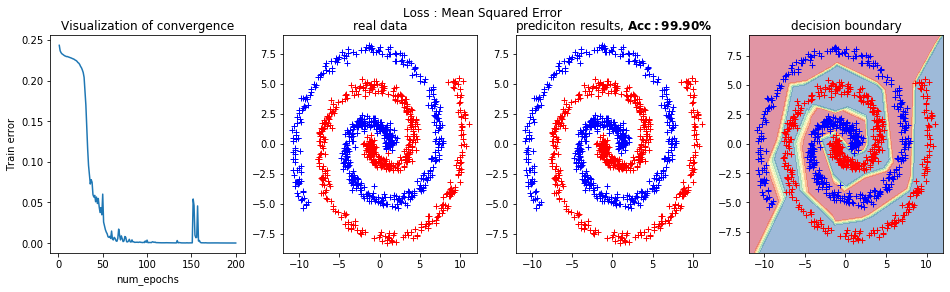

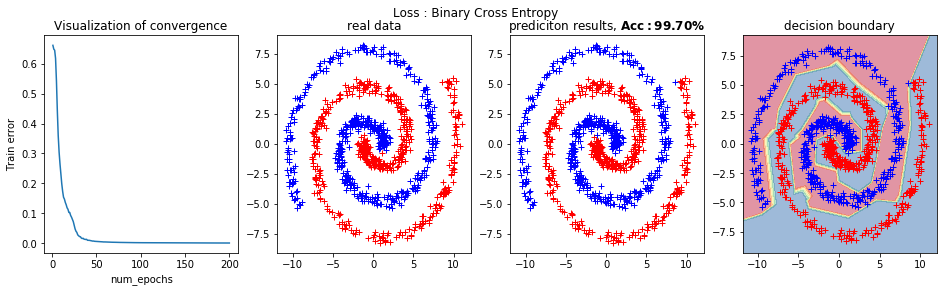

In [47]:
#---------------------------------------------------------------------------------------- MSE
criterion = nn.MSELoss()
### Train the model
model = MultiLayerModel(n_hidden_layers=3, n_neurons=7, 
                        hidden_activations=torch.relu, output_activation=torch.sigmoid)
#print('The model used is :\n', model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set, display=False)

### Evaluate the model and plot the results
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)
acc = accuracy(y_val, y_pre, return_value=True, display=False)
compare_pred(X_val, y_val, y_pre, model, train_error, accuracy=acc, title='Loss : Mean Squared Error')


#---------------------------------------------------------------------------------------- BCE
criterion = nn.BCEWithLogitsLoss()
### Train the model
model = MultiLayerModel(n_hidden_layers=3, n_neurons=7, 
                        hidden_activations=torch.relu, output_activation=lambda x:x)
#print('The model used is :\n', model)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set, display=False)

### Evaluate the model and plot the results
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)
acc = accuracy(y_val, y_pre, return_value=True, display=False)
compare_pred(X_val, y_val, y_pre, model, train_error, accuracy=acc, title='Loss : Binary Cross Entropy', 
             no_sigmoid=True)

> Comments : Very weird results, it appears that when using BCE, the model only converges when using Adagrad. Adam yields very bad results, SGD also... Anyway, we observe that using BCE smoothes the training curve, yields great results in terms of performance as well as with MSE. The decision boundary is a bit thiner but very edgier than when using MSE.

---
---
---

### Exercice 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [48]:
# Here is a test dataset. Use it similarly to the validaiton dataset above
# to compute the final performance of your model
X_test, y_test = generate_data(500)
y_test = y_test.type(torch.float32)

In [49]:
### Evaluate the model and plot the results
model.eval() # set the model to test mode
with torch.no_grad():
    y_final = torch.sigmoid(model(X_test)).view(-1)
acc = accuracy(y_final, y_test, display=True)

Accuracy of the network on the 1000 validation data: 99.91 %
